## Baseline Models

In [1]:
## imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
## Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [3]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [4]:
## Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
from items import Item

In [6]:
%matplotlib inline

### Loading the pkl files

In [7]:
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [9]:
print(train[0].price)

11.99


In [10]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

### Feature Engineering (Before fitting the LR Model)

In [11]:
## Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [12]:
train[0].features.keys()

dict_keys(['Manufacturer', 'Part Number', 'Item Weight', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Included Components', 'Batteries Included?', 'Batteries Required?', 'Warranty Description', 'Best Sellers Rank', 'Date First Available'])

In [13]:
## Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 23322),
 ('Best Sellers Rank', 22032),
 ('Item Weight', 19910),
 ('Item model number', 17497),
 ('Manufacturer', 16933),
 ('Part Number', 16589),
 ('Batteries Required?', 14820),
 ('Brand', 13896),
 ('Product Dimensions', 13718),
 ('Batteries Included?', 12152),
 ('Is Discontinued By Manufacturer', 9299),
 ('Color', 8932),
 ('Material', 8867),
 ('Package Dimensions', 7727),
 ('Brand Name', 6170),
 ('Included Components', 5961),
 ('Item Package Quantity', 5508),
 ('Country of Origin', 5105),
 ('Model Info', 4653),
 ('Special Features', 3284),
 ('Shape', 3157),
 ('Number of Pieces', 3136),
 ('Special Feature', 3131),
 ('Material Type', 2764),
 ('Style', 2686),
 ('Voltage', 2501),
 ('Size', 2405),
 ('Item Dimensions LxWxH', 2346),
 ('Unit Count', 2088),
 ('External Testing Certification', 1959),
 ('Compatible Devices', 1888),
 ('Finish Type', 1874),
 ('Warranty Description', 1778),
 ('Capacity', 1737),
 ('Number of Items', 1405),
 ('Duration', 1329),
 ('Power Sou

In [14]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [15]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [16]:
average_weight = sum(weights)/len(weights)
average_weight

3.9558465173350643

In [17]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [18]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [19]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

238325.0414017561

In [20]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [21]:
def get_text_length(item):
    return len(item.test_prompt())

In [22]:
## investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

brands.most_common(40)

[('Upstart Battery', 483),
 ('GE', 480),
 ('Whirlpool', 466),
 ('Frigidaire', 406),
 ('Supplying Demand', 277),
 ('UpStart Components', 198),
 ('SAMSUNG', 182),
 ('BlueStars', 158),
 ('Supco', 134),
 ('ICEPURE', 133),
 ('LG', 121),
 ('Broan-NuTone', 98),
 ('Lifetime Appliance Parts', 89),
 ('AMI PARTS', 88),
 ('PartsBroz', 82),
 ('Waterdrop', 77),
 ('Swift Green Filters', 71),
 ('Beaquicy', 71),
 ('Air Filter Factory', 67),
 ('Nostalgic Warehouse', 66),
 ('Generic', 65),
 ('Electrolux', 62),
 ('PUREPLUS', 58),
 ('Melitta', 57),
 ('HQRP', 56),
 ('Wowfeel', 55),
 ('Empava', 55),
 ('Aqua Fresh', 53),
 ('Edgewater Parts', 49),
 ('Tier1', 48),
 ('AQUA CREST', 48),
 ('COSTWAY', 47),
 ('Refresh', 47),
 ('Denali Pure', 46),
 ('BUNN', 46),
 ('BRBHOM', 44),
 ('GOLDEN ICEPURE', 44),
 ('EXCELPURE', 43),
 ('Seentech', 42),
 ('Range Kleen', 41)]

In [23]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [24]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [25]:
get_features(train[0])

{'weight': 1.17,
 'rank': 81103.0,
 'text_length': 703,
 'is_top_electronics_brand': 0}

In [26]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [29]:
train_df

,weight,rank,text_length,is_top_electronics_brand,price
0,1.170000,81103.000000,703,0,11.99
1,55.000000,1356.500000,771,0,261.27
2,3.690000,62834.000000,671,0,84.99
3,0.437500,111305.000000,651,0,15.14
4,3.955847,238325.041402,861,0,21.99
...,...,...,...,...,...
24995,1.000000,108431.500000,820,0,43.99
24996,2.350000,382455.000000,819,0,191.25
24997,0.375000,31190.000000,884,0,49.95
24998,59.000000,743.000000,841,0,899.95


In [30]:
test_df

,weight,rank,text_length,is_top_electronics_brand,price
0,3.955847,1444.000000,889,0,65.99
1,3.955847,238325.041402,669,0,9.68
2,3.955847,238325.041402,810,0,155.98
3,0.019813,238325.041402,849,0,5.59
4,0.000625,151219.000000,881,0,98.40
...,...,...,...,...,...
245,0.400000,97538.000000,902,0,50.25
246,4.800000,265150.000000,952,0,101.36
247,0.462500,22770.000000,761,0,4.98
248,3.955847,238325.041402,845,0,9.89


### Linear Regression Model

In [27]:
np.random.seed(42)

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 4.99356608406799
rank: -1.4753193495318485e-05
text_length: 0.0343739375433114
is_top_electronics_brand: 5.965762485264699
Intercept: 15.561992621834023
Mean Squared Error: 3988.535304967361
R-squared Score: 0.6053483396480275


In [28]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $65.85 Truth: $65.99 Error: $0.14 SLE: 0.00 Item: Setpower Insulated Protective Cover for ...
2: Guess: $54.80 Truth: $9.68 Error: $45.12 SLE: 2.73 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $59.64 Truth: $155.98 Error: $96.34 SLE: 0.90 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $41.33 Truth: $5.59 Error: $35.74 SLE: 3.46 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $43.62 Truth: $98.40 Error: $54.78 SLE: 0.64 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $43.55 Truth: $54.99 Error: $11.44 SLE: 0.05 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $60.98 Truth: $5.71 Error: $55.27 SLE: 4.94 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $40.62 Truth: $9.53 Error: $31.09 SLE: 1.89 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $36.66 Truth: $11.24 Error: $25.42 SLE: 1.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $36.32 Truth: $12.88 Error: $23.44 SLE: 0.98 Item: Away NV35

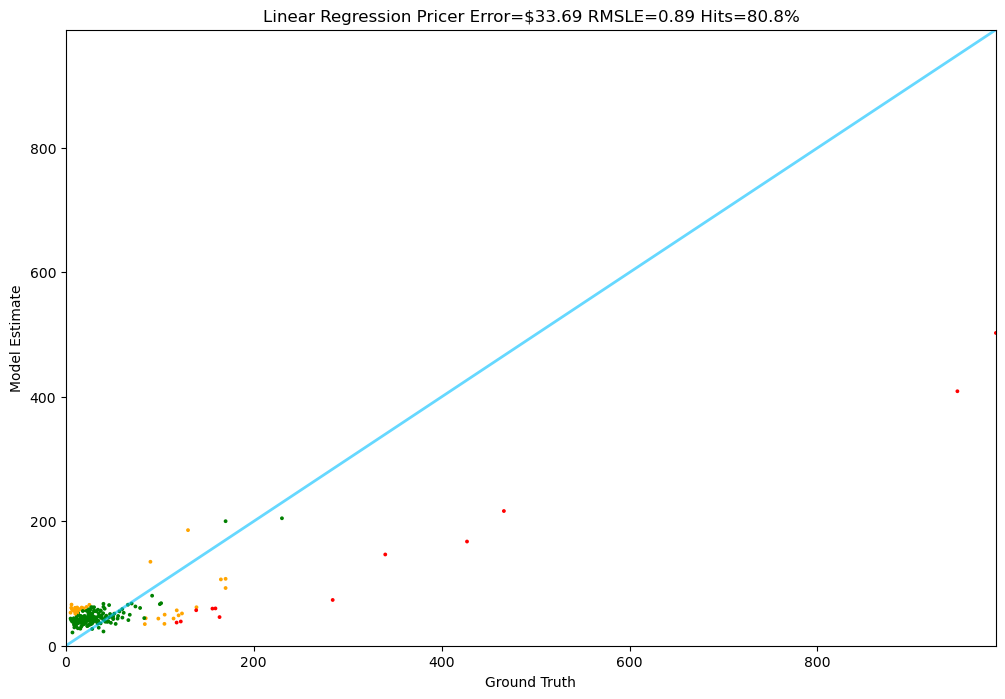

In [31]:
## Testing it
Tester.test(linear_regression_pricer)

### Linear Regression Model with count vectorizer

In [32]:
# For the next few models, it prepare the documents and prices
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [35]:
## Use the CountVectorizer for a Bag of Words model
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [36]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $26.13 Truth: $65.99 Error: $39.86 SLE: 0.82 Item: Setpower Insulated Protective Cover for ...
2: Guess: $36.82 Truth: $9.68 Error: $27.14 SLE: 1.60 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $77.52 Truth: $155.98 Error: $78.46 SLE: 0.48 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $29.89 Truth: $5.59 Error: $24.30 SLE: 2.39 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $156.96 Truth: $98.40 Error: $58.56 SLE: 0.21 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $0.00 Truth: $54.99 Error: $54.99 SLE: 16.20 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $0.00 Truth: $5.71 Error: $5.71 SLE: 3.62 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $31.10 Truth: $9.53 Error: $21.57 SLE: 1.24 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $33.26 Truth: $11.24 Error: $22.02 SLE: 1.06 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $108.18 Truth: $12.88 Error: $95.30 SLE: 4.25 Item: Away NV3

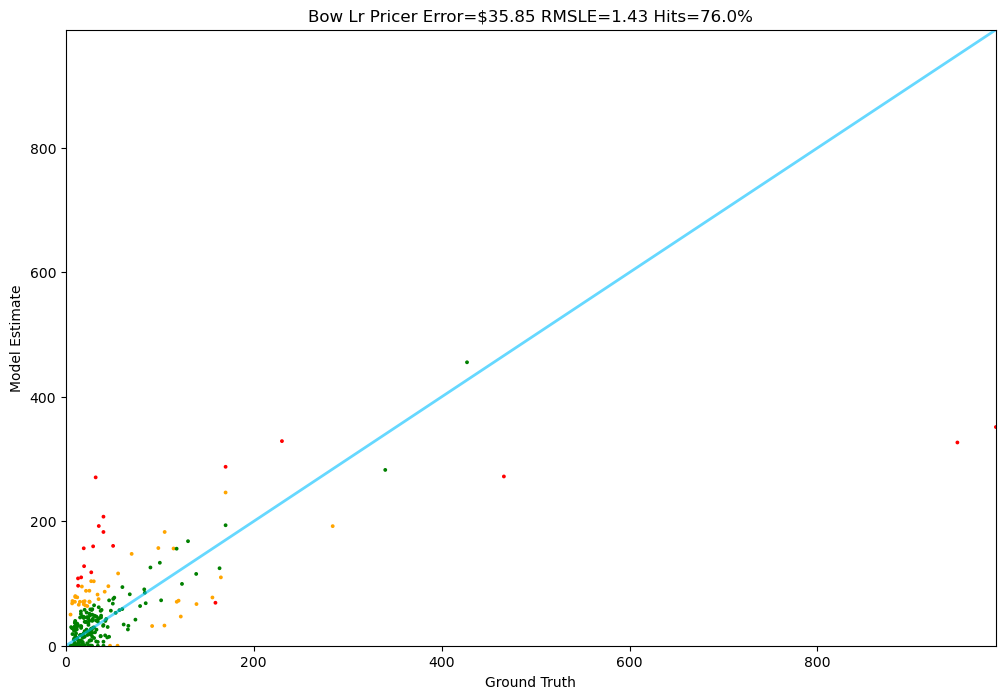

In [37]:
Tester.test(bow_lr_pricer)

### Linear Regression Model with word2vec

In [38]:
np.random.seed(42)

## Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

## Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [39]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

## Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [40]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [41]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $47.75 Truth: $65.99 Error: $18.24 SLE: 0.10 Item: Setpower Insulated Protective Cover for ...
2: Guess: $39.17 Truth: $9.68 Error: $29.49 SLE: 1.75 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $153.22 Truth: $155.98 Error: $2.76 SLE: 0.00 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $76.58 Truth: $5.59 Error: $70.99 SLE: 6.08 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $106.15 Truth: $98.40 Error: $7.75 SLE: 0.01 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $48.56 Truth: $54.99 Error: $6.43 SLE: 0.01 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $34.89 Truth: $5.71 Error: $29.18 SLE: 2.81 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $0.00 Truth: $9.53 Error: $9.53 SLE: 5.54 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $12.98 Truth: $11.24 Error: $1.74 SLE: 0.02 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $73.07 Truth: $12.88 Error: $60.19 SLE: 2.80 Item: Away NV350 N

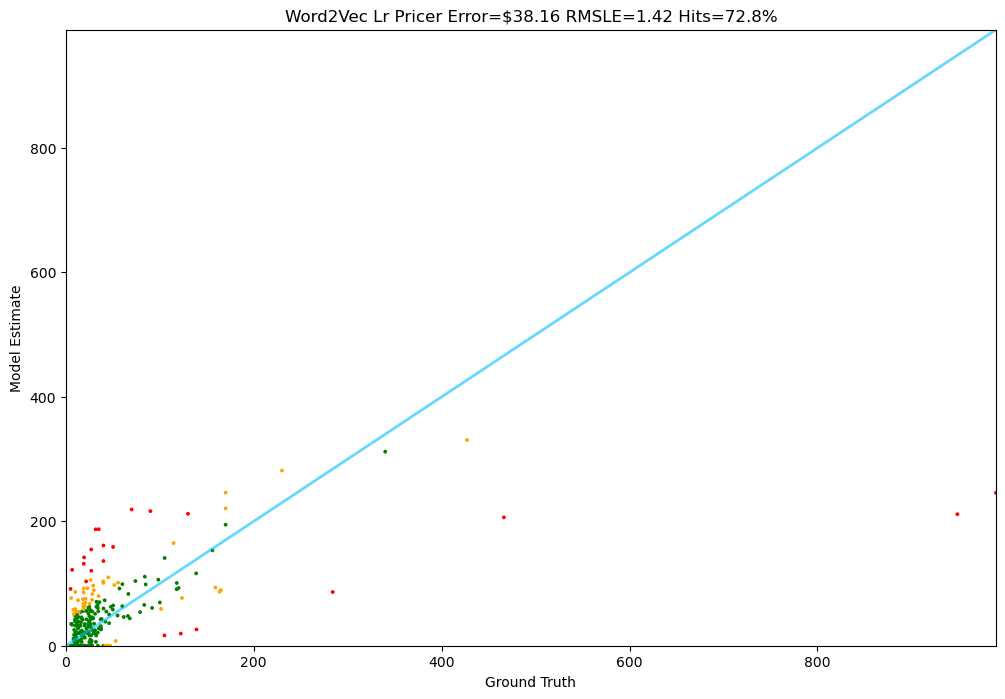

In [42]:
Tester.test(word2vec_lr_pricer)

### Support Vector Regressor with word2vec

In [43]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [44]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $36.48 Truth: $65.99 Error: $29.51 SLE: 0.34 Item: Setpower Insulated Protective Cover for ...
2: Guess: $28.12 Truth: $9.68 Error: $18.44 SLE: 1.01 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $45.35 Truth: $155.98 Error: $110.63 SLE: 1.49 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $21.88 Truth: $5.59 Error: $16.29 SLE: 1.55 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $105.78 Truth: $98.40 Error: $7.38 SLE: 0.01 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $28.33 Truth: $54.99 Error: $26.66 SLE: 0.42 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $24.20 Truth: $5.71 Error: $18.49 SLE: 1.75 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $27.52 Truth: $9.53 Error: $17.99 SLE: 0.99 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $26.34 Truth: $11.24 Error: $15.10 SLE: 0.65 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $26.15 Truth: $12.88 Error: $13.27 SLE: 0.45 Item: Away NV

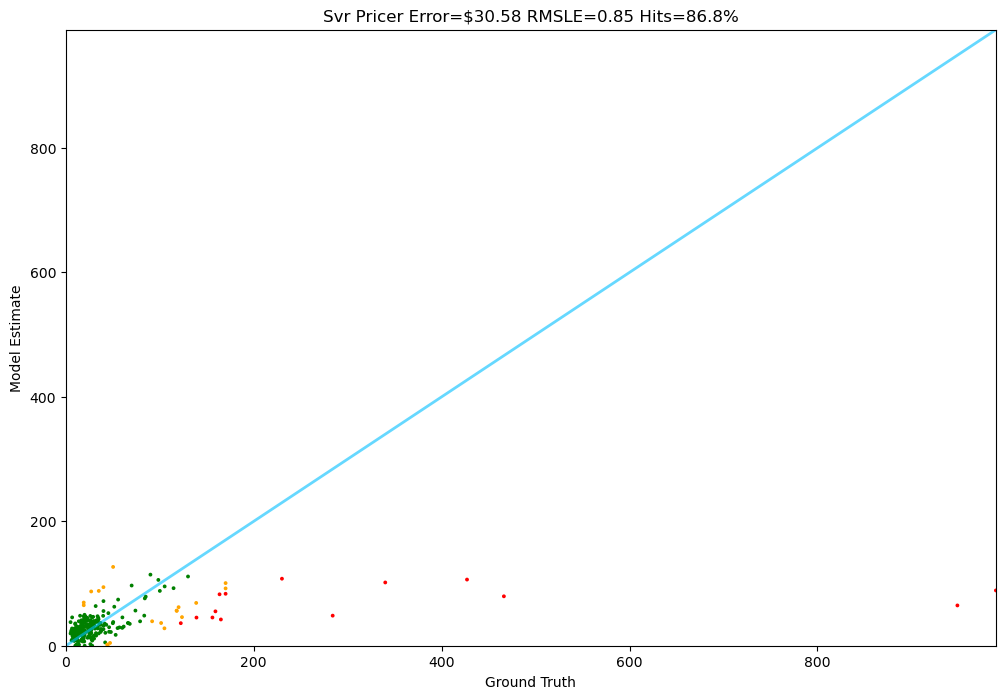

In [45]:
Tester.test(svr_pricer)

### Random Forest Model with word2vec

In [46]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $38.08 Truth: $65.99 Error: $27.91 SLE: 0.29 Item: Setpower Insulated Protective Cover for ...
2: Guess: $25.83 Truth: $9.68 Error: $16.15 SLE: 0.85 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $212.22 Truth: $155.98 Error: $56.24 SLE: 0.09 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $24.32 Truth: $5.59 Error: $18.73 SLE: 1.81 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $140.20 Truth: $98.40 Error: $41.80 SLE: 0.12 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $101.45 Truth: $54.99 Error: $46.46 SLE: 0.37 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $43.58 Truth: $5.71 Error: $37.87 SLE: 3.59 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $34.39 Truth: $9.53 Error: $24.86 SLE: 1.47 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $19.63 Truth: $11.24 Error: $8.39 SLE: 0.27 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $54.16 Truth: $12.88 Error: $41.28 SLE: 1.90 Item: Away N

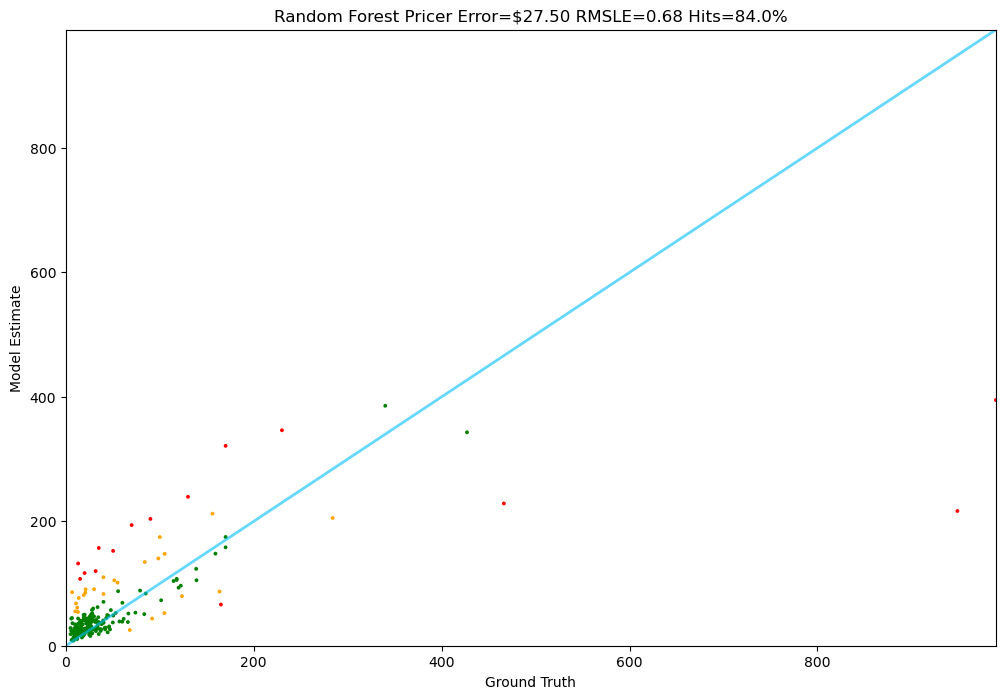

In [48]:
Tester.test(random_forest_pricer)